In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

In [2]:
#function for identifying length of homopolymer runs
def homopolymer_len(context):
    run=1
    last_base={"A":0,"C":0,"G":0,"T":0}
    prev_base=context[0]
    
    for i, base in enumerate(context):
        if prev_base in base and i!=0:
            run += 1
            last_base[base] = max(run, last_base[base])
        else:
            run=1
        prev_base=base

    longest=max(last_base.values())

    return longest

5046


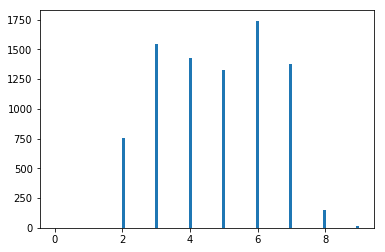

In [10]:
indel_file="indelocator_file.txt"
output_filename="homopolymer_filtered.txt"

maf=pd.read_csv(indel_file,sep='\t',dtype=object,encoding = "ISO-8859-1")

maf['ref_context']=maf['ref_context'].str.upper()
maf['homopolymer_len']=0

for idx,row in maf.iterrows():
    maf.loc[idx,'homopolymer_len']=homopolymer_len(row['ref_context'])

plt.gcf().clear()
plt.hist(maf['homopolymer_len'],bins=100)
plt.savefig("indel_muts/homopolymer_length_plot")

#filter out mutations found in homopolymer runs greater than 6 due to indelocator inaccuracies
maf=maf[maf['homopolymer_len']<=5]
maf.to_csv(output_filename,sep='\t',index=False)

Eliminate sites with depth 3X higher than expected from SNVs (or outside poisson expectation), similar to the Strelka implementation

In [12]:
indel_file="indelocator_file.txt"
snv_file="snvs.txt"
output="poisson_depth_filt.txt"

maf=pd.read_csv(indel_file,sep='\t')
print(len(maf['Tumor_Sample_Barcode'].unique()))
depth_maf=pd.read_csv(snv_file,sep='\t')

depth_maf=depth_maf[~((depth_maf['t_alt_count'].str.contains("\|",na=False))|
                     (depth_maf['t_ref_count'].str.contains("\|",na=False)))]

maf['depth']=pd.to_numeric(maf['t_alt_count'])+pd.to_numeric(maf['t_ref_count'])
depth_maf['depth']=pd.to_numeric(depth_maf['t_alt_count'])+pd.to_numeric(depth_maf['t_ref_count'])

median_snv_depths=depth_maf.groupby(['Tumor_Sample_Barcode'])['depth'].median().reset_index(name='median_depth')

maf=maf.merge(median_snv_depths,on='Tumor_Sample_Barcode')
print(len(maf['Tumor_Sample_Barcode'].unique()))

maf['depth_poisson']=stats.poisson.cdf(maf['depth'],maf['median_depth'])

#filter out indels found at a depth greater than poisson expectation set by the SNVs
maf=maf[maf['depth_poisson']<0.99]

maf.to_csv(output,sep='\t',index=False)


1292
1292
4459
2158


Filter out indels longer than 10 base pairs to prevent the inclusion inaccurately counted of split reads

/Users/mleventh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (52,72,80,83,84,147,148,156,157,169,170,171,172,173,174,188,312) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


136


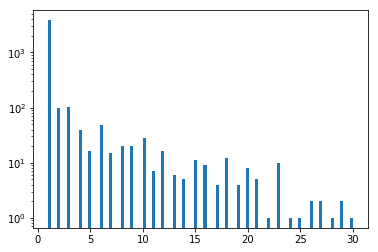

In [13]:
indel_file="indel_muts/poisson_depth_filt_noAltLim.txt"
output_file="indel_muts/short_indels_noAltLim.txt"

indel_maf=pd.read_csv(indel_file,sep='\t')

indel_maf['alt_len']=indel_maf['Tumor_Seq_Allele2'].str.len()
indel_maf['ref_len']=indel_maf['Reference_Allele'].str.len()

combined_counts=pd.concat([indel_maf['alt_len'],indel_maf['ref_len']])

filtered_count=indel_maf.groupby(['Genome_Change']).size().reset_index(name='site_counts')

plt.gcf().clear()
plt.hist(combined_counts,bins=100,log=True)

indel_maf=indel_maf[(indel_maf['alt_len']<=10)&(indel_maf['ref_len']<=10)]


indel_maf.to_csv(output_file,sep='\t',index=False)